# **Import Library**

In [46]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

# **Load Dataset (Train/Test + LOA Features)**

In [47]:
train_full = pd.read_csv("train.csv")
test_full  = pd.read_csv("test.csv")

y_train = train_full["y_raw"]
y_test  = test_full["y_raw"]

# LOA features
X_train_rf  = pd.read_csv("X_train_rf.csv")
X_test_rf   = pd.read_csv("X_test_rf.csv")

X_train_ab  = pd.read_csv("X_train_ab.csv")
X_test_ab   = pd.read_csv("X_test_ab.csv")

X_train_xgb = pd.read_csv("X_train_xgb.csv")
X_test_xgb  = pd.read_csv("X_test_xgb.csv")

# ALL FEATURES
X_train_all = train_full.drop(columns=["y_raw"])
X_test_all  = test_full.drop(columns=["y_raw"])

# **Fungsi compute_metrics() untuk Train & Test**

In [48]:
def compute_metrics(model, X, y):
    pred = model.predict(X)
    acc = accuracy_score(y, pred)
    prec = precision_score(y, pred)
    rec = recall_score(y, pred)
    f1 = f1_score(y, pred)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "TP": tp, "FP": fp, "TN": tn, "FN": fn
    }

In [49]:
def evaluate_and_collect_metrics(model, X_train, y_train, X_test, y_test, model_name):
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_test)

    train_acc  = accuracy_score(y_train, pred_train)
    test_acc   = accuracy_score(y_test, pred_test)
    train_prec = precision_score(y_train, pred_train)
    test_prec  = precision_score(y_test, pred_test)
    train_rec  = recall_score(y_train, pred_train)
    test_rec   = recall_score(y_test, pred_test)
    train_f1   = f1_score(y_train, pred_train)
    test_f1    = f1_score(y_test, pred_test)

    tn, fp, fn, tp = confusion_matrix(y_test, pred_test).ravel()

    # PRINT METRICS
    print(f"\n===== {model_name} =====")
    print(f"Train Accuracy : {train_acc}")
    print(f"Test  Accuracy : {test_acc}")
    print(f"Precision      : {test_prec}")
    print(f"Recall         : {test_rec}")
    print(f"F1 Score       : {test_f1}")
    print(f"TN={tn} FP={fp} FN={fn} TP={tp}")

    # CONFUSION MATRIX VISUAL
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, pred_test), annot=True, fmt="d",
                cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {
        "model_name": model_name,
        "train_acc": train_acc, "test_acc": test_acc,
        "train_prec": train_prec, "test_prec": test_prec,
        "train_rec": train_rec, "test_rec": test_rec,
        "train_f1": train_f1,   "test_f1": test_f1,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

# **BAGIAN A — LOA FEATURES**

## **Baseline Models (Before Tuning)**

In [50]:
baseline_rf_LOA  = RandomForestClassifier(random_state=42)
baseline_ab_LOA  = AdaBoostClassifier(random_state=42)
baseline_xgb_LOA = XGBClassifier(eval_metric='logloss', random_state=42)

baseline_rf_LOA.fit(X_train_rf,  y_train)
baseline_ab_LOA.fit(X_train_ab,  y_train)
baseline_xgb_LOA.fit(X_train_xgb, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## **GridSearch (LOA Models)**



### **Random Forest**

In [51]:
rf_param = {
    'n_estimators': [500, 800, 1200],
    'max_depth': [20, 30, None],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt', 0.2, 0.3]
}

rf_grid_LOA = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param, cv=5, scoring='f1', n_jobs=-1
)
rf_grid_LOA.fit(X_train_rf, y_train)
model_rf_LOA = rf_grid_LOA.best_estimator_

print("Best RF params (LOA):", rf_grid_LOA.best_params_)

Best RF params (LOA): {'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


### **AdaBoost**

In [53]:
ab_param = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.1, 0.2, 0.5],
    'estimator': [DecisionTreeClassifier(max_depth=d) for d in [2, 3, 4, 5]]
}

ab_grid_LOA = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    ab_param, cv=5, scoring='f1', n_jobs=-1
)

ab_grid_LOA.fit(X_train_ab, y_train)
model_ab_LOA = ab_grid_LOA.best_estimator_

print("Best AB params (LOA):", ab_grid_LOA.best_params_)

Best AB params (LOA): {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 200}


### **XGBoost**

In [54]:
xgb_param = {
    'n_estimators': [150, 200, 300],
    'max_depth': [3, 4],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0]
}

xgb_grid_LOA = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42, tree_method='hist'),
    xgb_param, cv=5, scoring='f1', n_jobs=-1
)

xgb_grid_LOA.fit(X_train_xgb, y_train)
model_xgb_LOA = xgb_grid_LOA.best_estimator_

print("Best XGB params (LOA):", xgb_grid_LOA.best_params_)

Best XGB params (LOA): {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


## **Voting Classifier — LOA**

In [55]:
pred_rf  = model_rf_LOA.predict(X_test_rf)
pred_ab  = model_ab_LOA.predict(X_test_ab)
pred_xgb = model_xgb_LOA.predict(X_test_xgb)

pred_matrix = np.vstack([pred_rf, pred_ab, pred_xgb]).T
voted_pred_LOA = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, pred_matrix)

tn, fp, fn, tp = confusion_matrix(y_test, voted_pred_LOA).ravel()

voting_metrics_LOA = {
    "Accuracy": accuracy_score(y_test, voted_pred_LOA),
    "Precision": precision_score(y_test, voted_pred_LOA),
    "Recall": recall_score(y_test, voted_pred_LOA),
    "F1": f1_score(y_test, voted_pred_LOA),
    "TP": tp, "FP": fp, "TN": tn, "FN": fn
}

## **Tabel TRAINING (Before vs After)**

In [56]:
train_results_LOA = {
    "RF (Before)": compute_metrics(baseline_rf_LOA, X_train_rf, y_train),
    "AB (Before)": compute_metrics(baseline_ab_LOA, X_train_ab, y_train),
    "XGB (Before)": compute_metrics(baseline_xgb_LOA, X_train_xgb, y_train),
    "RF (After)": compute_metrics(model_rf_LOA, X_train_rf, y_train),
    "AB (After)": compute_metrics(model_ab_LOA, X_train_ab, y_train),
    "XGB (After)": compute_metrics(model_xgb_LOA, X_train_xgb, y_train)
}

df_train_LOA = pd.DataFrame(train_results_LOA).T

## **Tabel TESTING (Before vs After + Voting)**

In [57]:
test_results_LOA = {
    "RF (Before)": compute_metrics(baseline_rf_LOA, X_test_rf, y_test),
    "AB (Before)": compute_metrics(baseline_ab_LOA, X_test_ab, y_test),
    "XGB (Before)": compute_metrics(baseline_xgb_LOA, X_test_xgb, y_test),
    "RF (After)": compute_metrics(model_rf_LOA, X_test_rf, y_test),
    "AB (After)": compute_metrics(model_ab_LOA, X_test_ab, y_test),
    "XGB (After)": compute_metrics(model_xgb_LOA, X_test_xgb, y_test),
    "Voting Ensemble": voting_metrics_LOA
}

df_test_LOA = pd.DataFrame(test_results_LOA).T


===== Random Forest (Tuned LOA) =====
Train Accuracy : 1.0
Test  Accuracy : 0.7192982456140351
Precision      : 0.6842105263157895
Recall         : 0.8666666666666667
F1 Score       : 0.7647058823529411
TN=15 FP=12 FN=4 TP=26


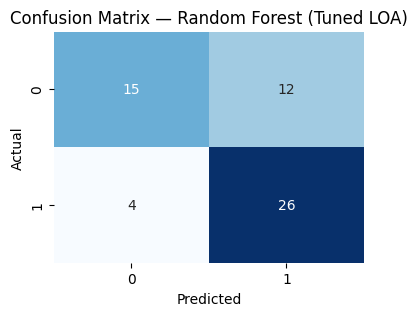


===== AdaBoost (Tuned LOA) =====
Train Accuracy : 1.0
Test  Accuracy : 0.6666666666666666
Precision      : 0.6571428571428571
Recall         : 0.7666666666666667
F1 Score       : 0.7076923076923077
TN=15 FP=12 FN=7 TP=23


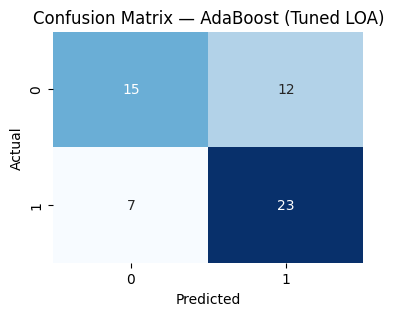


===== XGBoost (Tuned LOA) =====
Train Accuracy : 1.0
Test  Accuracy : 0.7017543859649122
Precision      : 0.7241379310344828
Recall         : 0.7
F1 Score       : 0.711864406779661
TN=19 FP=8 FN=9 TP=21


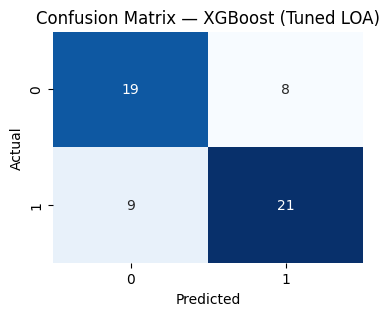


===== Random Forest (Baseline LOA) =====
Train Accuracy : 1.0
Test  Accuracy : 0.6491228070175439
Precision      : 0.6470588235294118
Recall         : 0.7333333333333333
F1 Score       : 0.6875
TN=15 FP=12 FN=8 TP=22


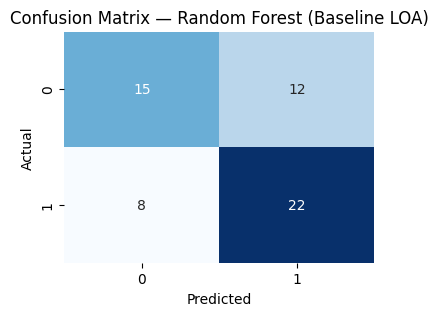


===== AdaBoost (Baseline LOA) =====
Train Accuracy : 1.0
Test  Accuracy : 0.6666666666666666
Precision      : 0.6571428571428571
Recall         : 0.7666666666666667
F1 Score       : 0.7076923076923077
TN=15 FP=12 FN=7 TP=23


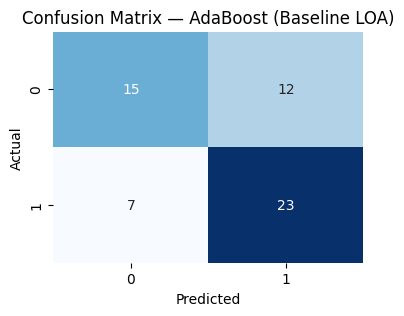


===== XGBoost (Baseline LOA) =====
Train Accuracy : 1.0
Test  Accuracy : 0.6491228070175439
Precision      : 0.6470588235294118
Recall         : 0.7333333333333333
F1 Score       : 0.6875
TN=15 FP=12 FN=8 TP=22


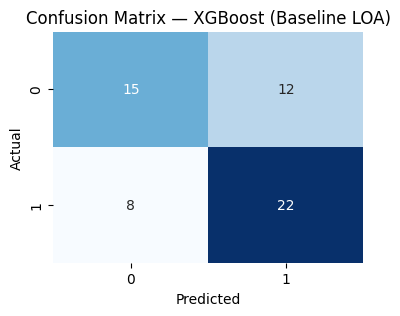

In [58]:
metrics_rf_tuned  = evaluate_and_collect_metrics(model_rf_LOA,  X_train_rf,  y_train, X_test_rf,  y_test, "Random Forest (Tuned LOA)")
metrics_ab_tuned  = evaluate_and_collect_metrics(model_ab_LOA,  X_train_ab,  y_train, X_test_ab,  y_test, "AdaBoost (Tuned LOA)")
metrics_xgb_tuned = evaluate_and_collect_metrics(model_xgb_LOA, X_train_xgb, y_train, X_test_xgb, y_test, "XGBoost (Tuned LOA)")

metrics_rf_base  = evaluate_and_collect_metrics(baseline_rf_LOA,  X_train_rf, y_train, X_test_rf, y_test, "Random Forest (Baseline LOA)")
metrics_ab_base  = evaluate_and_collect_metrics(baseline_ab_LOA,  X_train_ab, y_train, X_test_ab, y_test, "AdaBoost (Baseline LOA)")
metrics_xgb_base = evaluate_and_collect_metrics(baseline_xgb_LOA, X_train_xgb, y_train, X_test_xgb, y_test, "XGBoost (Baseline LOA)")

## **Visualisasi Before vs After vs Difference**

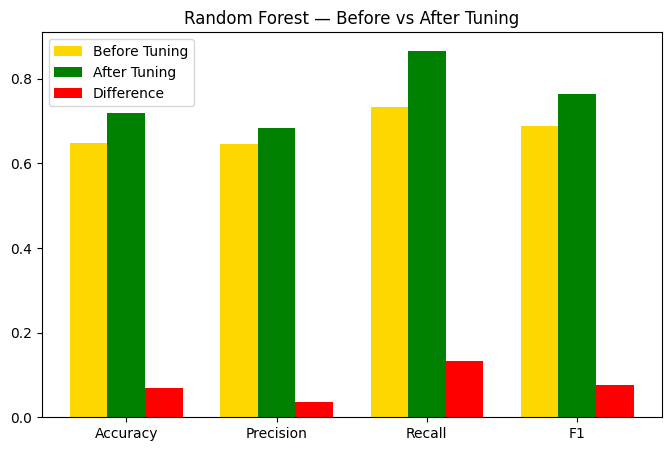

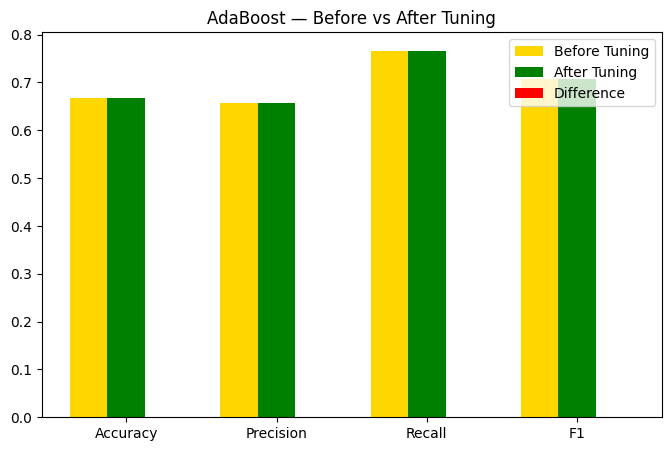

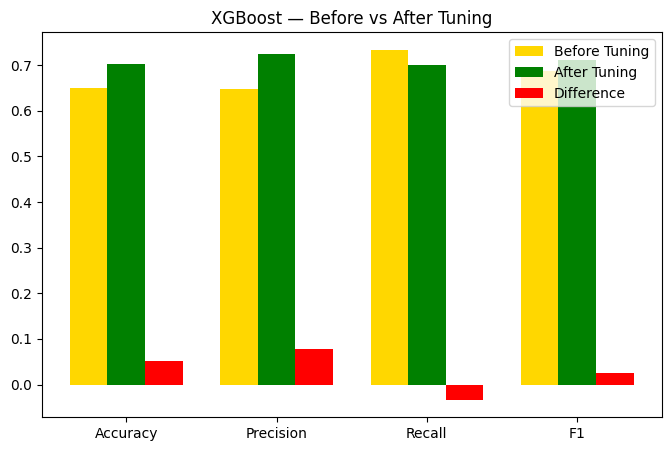

In [59]:
def plot_compare(title, before, after):
    diff = after - before

    labels = ["Accuracy", "Precision", "Recall", "F1"]
    x = np.arange(len(labels))

    plt.figure(figsize=(8, 5))
    plt.bar(x-0.25, before, width=0.25, label="Before Tuning", color="gold")
    plt.bar(x, after, width=0.25, label="After Tuning", color="green")
    plt.bar(x+0.25, diff, width=0.25, label="Difference", color="red")

    plt.xticks(x, labels)
    plt.title(title)
    plt.legend()
    plt.show()


# RF Plot
plot_compare(
    "Random Forest — Before vs After Tuning",
    df_test.loc["Random Forest (Before Tuning)", ["Accuracy","Precision","Recall","F1"]].values,
    df_test.loc["Random Forest (After Tuning)", ["Accuracy","Precision","Recall","F1"]].values
)

# AdaBoost Plot
plot_compare(
    "AdaBoost — Before vs After Tuning",
    df_test.loc["AdaBoost (Before Tuning)", ["Accuracy","Precision","Recall","F1"]].values,
    df_test.loc["AdaBoost (After Tuning)", ["Accuracy","Precision","Recall","F1"]].values
)

# XGBoost Plot
plot_compare(
    "XGBoost — Before vs After Tuning",
    df_test.loc["XGBoost (Before Tuning)", ["Accuracy","Precision","Recall","F1"]].values,
    df_test.loc["XGBoost (After Tuning)", ["Accuracy","Precision","Recall","F1"]].values
)

# **BAGIAN B — ALL FEATURES**

## **Baseline Models — All Features**

In [60]:
baseline_rf_ALL  = RandomForestClassifier(random_state=42)
baseline_ab_ALL  = AdaBoostClassifier(random_state=42)
baseline_xgb_ALL = XGBClassifier(eval_metric='logloss', random_state=42)

baseline_rf_ALL.fit(X_train_all, y_train)
baseline_ab_ALL.fit(X_train_all, y_train)
baseline_xgb_ALL.fit(X_train_all, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## **GridSearch — All Features**

### **Random Forest**

In [61]:
rf_grid_ALL = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param, cv=5, scoring='f1', n_jobs=-1
)

rf_grid_ALL.fit(X_train_all, y_train)
model_rf_ALL = rf_grid_ALL.best_estimator_

print("Best RF params (ALL):", rf_grid_ALL.best_params_)

Best RF params (ALL): {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1200}


### **AdaBoost**

In [62]:
ab_grid_ALL = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    ab_param, cv=5, scoring='f1', n_jobs=-1
)

ab_grid_ALL.fit(X_train_all, y_train)
model_ab_ALL = ab_grid_ALL.best_estimator_

print("Best AB params (ALL):", ab_grid_ALL.best_params_)

Best AB params (ALL): {'estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.5, 'n_estimators': 500}


### **XGBoost**

In [64]:
xgb_grid_ALL = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42, tree_method='hist'),
    xgb_param, cv=5, scoring='f1', n_jobs=-1
)

xgb_grid_ALL.fit(X_train_all, y_train)
model_xgb_ALL = xgb_grid_ALL.best_estimator_

print("Best XGB params (ALL):", xgb_grid_ALL.best_params_)

Best XGB params (ALL): {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.7}


## **Voting — All Features**

In [65]:
pred_rf  = model_rf_ALL.predict(X_test_all)
pred_ab  = model_ab_ALL.predict(X_test_all)
pred_xgb = model_xgb_ALL.predict(X_test_all)

pred_matrix_ALL = np.vstack([pred_rf, pred_ab, pred_xgb]).T
voted_pred_ALL = np.apply_along_axis(lambda x: np.bincount(x).argmax(), 1, pred_matrix_ALL)

tn, fp, fn, tp = confusion_matrix(y_test, voted_pred_ALL).ravel()

voting_metrics_ALL = {
    "Accuracy": accuracy_score(y_test, voted_pred_ALL),
    "Precision": precision_score(y_test, voted_pred_ALL),
    "Recall": recall_score(y_test, voted_pred_ALL),
    "F1": f1_score(y_test, voted_pred_ALL),
    "TP": tp, "FP": fp, "TN": tn, "FN": fn
}

## **Tabel Training & Testing — ALL FEATURES**

In [66]:
train_results_ALL = {
    "RF (Before)": compute_metrics(baseline_rf_ALL, X_train_all, y_train),
    "AB (Before)": compute_metrics(baseline_ab_ALL, X_train_all, y_train),
    "XGB (Before)": compute_metrics(baseline_xgb_ALL, X_train_all, y_train),
    "RF (After)": compute_metrics(model_rf_ALL, X_train_all, y_train),
    "AB (After)": compute_metrics(model_ab_ALL, X_train_all, y_train),
    "XGB (After)": compute_metrics(model_xgb_ALL, X_train_all, y_train),
    "Voting Ensemble": voting_metrics_ALL
}

df_train_ALL = pd.DataFrame(train_results_ALL).T


test_results_ALL = {
    "RF (Before)": compute_metrics(baseline_rf_ALL, X_test_all, y_test),
    "AB (Before)": compute_metrics(baseline_ab_ALL, X_test_all, y_test),
    "XGB (Before)": compute_metrics(baseline_xgb_ALL, X_test_all, y_test),
    "RF (After)": compute_metrics(model_rf_ALL, X_test_all, y_test),
    "AB (After)": compute_metrics(model_ab_ALL, X_test_all, y_test),
    "XGB (After)": compute_metrics(model_xgb_ALL, X_test_all, y_test),
    "Voting Ensemble": voting_metrics_ALL
}

df_test_ALL = pd.DataFrame(test_results_ALL).T


===== Random Forest (Tuned ALL) =====
Train Accuracy : 1.0
Test  Accuracy : 0.6842105263157895
Precision      : 0.6764705882352942
Recall         : 0.7666666666666667
F1 Score       : 0.71875
TN=16 FP=11 FN=7 TP=23


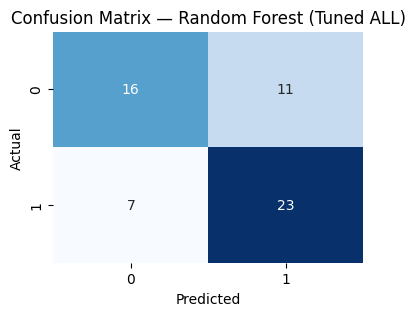


===== AdaBoost (Tuned ALL) =====
Train Accuracy : 1.0
Test  Accuracy : 0.631578947368421
Precision      : 0.6285714285714286
Recall         : 0.7333333333333333
F1 Score       : 0.676923076923077
TN=14 FP=13 FN=8 TP=22


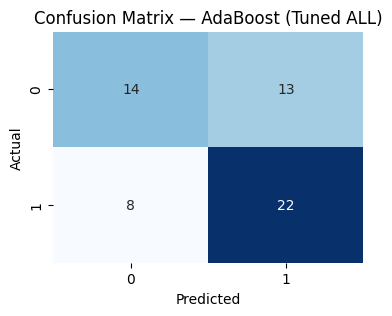


===== XGBoost (Tuned ALL) =====
Train Accuracy : 1.0
Test  Accuracy : 0.6491228070175439
Precision      : 0.6470588235294118
Recall         : 0.7333333333333333
F1 Score       : 0.6875
TN=15 FP=12 FN=8 TP=22


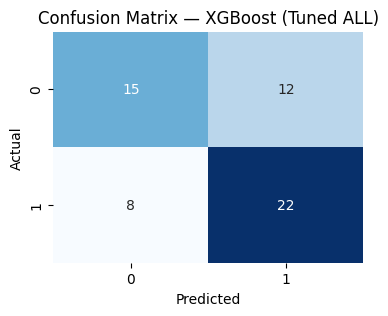


===== Random Forest (Baseline ALL) =====
Train Accuracy : 1.0
Test  Accuracy : 0.6842105263157895
Precision      : 0.6875
Recall         : 0.7333333333333333
F1 Score       : 0.7096774193548387
TN=17 FP=10 FN=8 TP=22


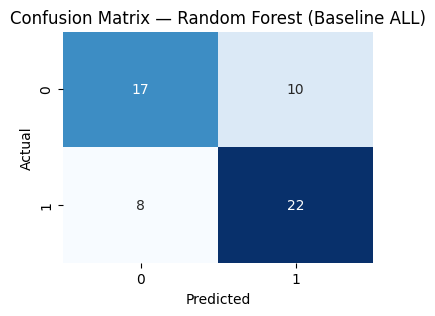


===== AdaBoost (Baseline ALL) =====
Train Accuracy : 1.0
Test  Accuracy : 0.7368421052631579
Precision      : 0.7419354838709677
Recall         : 0.7666666666666667
F1 Score       : 0.7540983606557377
TN=19 FP=8 FN=7 TP=23


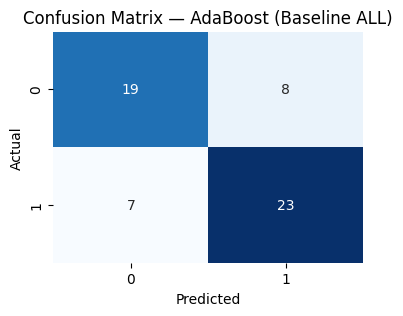


===== XGBoost (Baseline ALL) =====
Train Accuracy : 1.0
Test  Accuracy : 0.7017543859649122
Precision      : 0.6857142857142857
Recall         : 0.8
F1 Score       : 0.7384615384615385
TN=16 FP=11 FN=6 TP=24


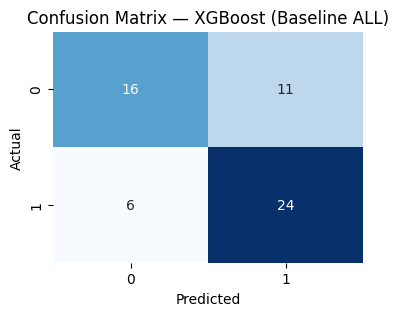

In [67]:
metrics_rf_tuned_all  = evaluate_and_collect_metrics(model_rf_ALL,  X_train_all,  y_train, X_test_all,  y_test, "Random Forest (Tuned ALL)")
metrics_ab_tuned_all  = evaluate_and_collect_metrics(model_ab_ALL,  X_train_all,  y_train, X_test_all,  y_test, "AdaBoost (Tuned ALL)")
metrics_xgb_tuned_all = evaluate_and_collect_metrics(model_xgb_ALL, X_train_all, y_train, X_test_all, y_test, "XGBoost (Tuned ALL)")

metrics_rf_base_all  = evaluate_and_collect_metrics(baseline_rf_ALL,  X_train_all, y_train, X_test_all, y_test, "Random Forest (Baseline ALL)")
metrics_ab_base_all  = evaluate_and_collect_metrics(baseline_ab_ALL,  X_train_all, y_train, X_test_all, y_test, "AdaBoost (Baseline ALL)")
metrics_xgb_base_all = evaluate_and_collect_metrics(baseline_xgb_ALL, X_train_all, y_train, X_test_all, y_test, "XGBoost (Baseline ALL)")

## **Visualisasi Before vs After vs Difference**

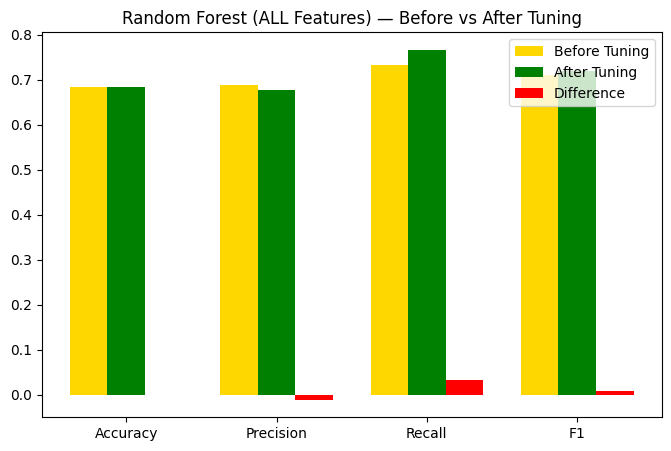

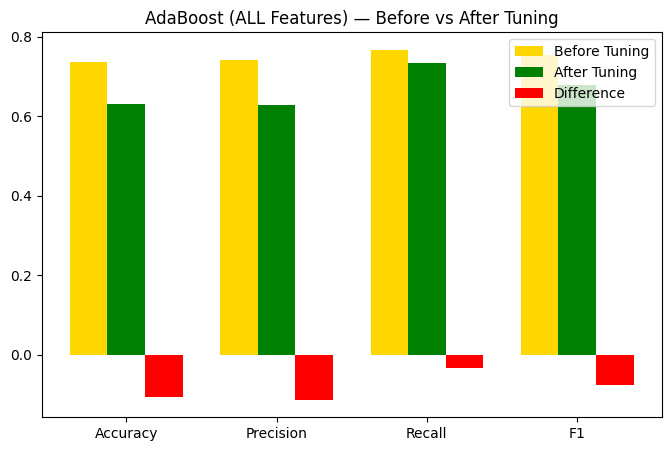

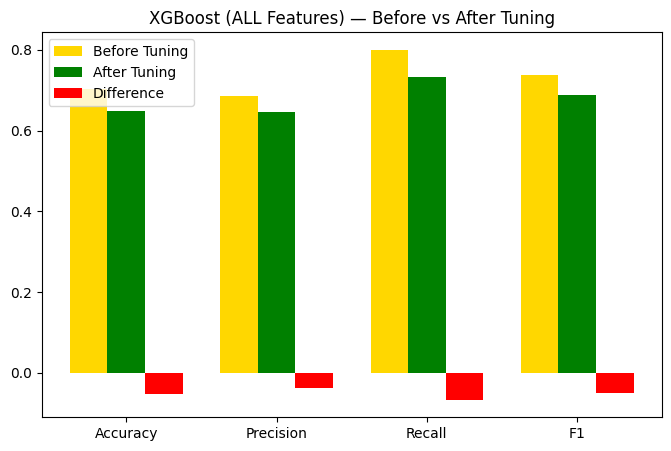

In [68]:
# Random Forest (ALL)
plot_compare(
    "Random Forest (ALL Features) — Before vs After Tuning",
    df_test_ALL.loc["RF (Before)", ["Accuracy","Precision","Recall","F1"]].values,
    df_test_ALL.loc["RF (After)",  ["Accuracy","Precision","Recall","F1"]].values
)

# AdaBoost (ALL)
plot_compare(
    "AdaBoost (ALL Features) — Before vs After Tuning",
    df_test_ALL.loc["AB (Before)", ["Accuracy","Precision","Recall","F1"]].values,
    df_test_ALL.loc["AB (After)",  ["Accuracy","Precision","Recall","F1"]].values
)

# XGBoost (ALL)
plot_compare(
    "XGBoost (ALL Features) — Before vs After Tuning",
    df_test_ALL.loc["XGB (Before)", ["Accuracy","Precision","Recall","F1"]].values,
    df_test_ALL.loc["XGB (After)",  ["Accuracy","Precision","Recall","F1"]].values
)

In [69]:
# ===============================
# SAVE OUTPUT TABLES TO CSV
# ===============================

# LOA Features
df_train_LOA.to_csv("training_results_LOA.csv")
df_test_LOA.to_csv("testing_results_LOA.csv")

# ALL Features
df_train_ALL.to_csv("training_results_ALL.csv")
df_test_ALL.to_csv("testing_results_ALL.csv")

print("Semua tabel berhasil disimpan sebagai CSV! ❤️")

Semua tabel berhasil disimpan sebagai CSV! ❤️
